In [2]:
# Some typical imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import streamlit as st

from collections import Counter
import plotly.express as px
import plotly.graph_objects as go

from itertools import chain
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from numba import jit # Compile some functions when performance is critical
import keras
from keras.initializers import RandomNormal
from keras.models import Model, load_model, save_model
from keras.layers import Embedding, Input, Dense, Concatenate, Multiply, Flatten
from keras.optimizers import Adam
import tensorflow as tf
    
print("Tensorflow version: {}".format(tf.__version__))

Using TensorFlow backend.


Tensorflow version: 2.1.0


In [ ]:
grid = pd.read_csv('final_game_user_grid.csv')
grid.info()

In [ ]:
grid = grid.dropna()
grid.shape

In [ ]:
grid.head()

In [ ]:
max_value_username = pd.DataFrame(grid.groupby('user_name')['max'].max().reset_index())
max_value_username.head()

In [ ]:
max_val_dict = max_value_username.groupby('user_name')['max'].apply(list).to_dict()

In [ ]:
grid['max_game'] = grid['user_name'].map(max_val_dict)
grid.head()

In [ ]:
grid['max_game_int'] = grid.max_game.str[0].astype(int)
grid = grid.drop('max_game', axis = 1)

In [ ]:
grid.sample(10)

In [ ]:
grid['score'] = grid['max']/grid['max_game_int']
grid.head()

In [ ]:
from sklearn.preprocessing import minmax_scale
grid['scaled_score'] = minmax_scale(grid['score'], feature_range=(1, 5))

In [ ]:
grid.to_csv('final_rating_game.csv', index = False)

# Game NeuralMF Hybrid Recommender
### In this notebook, we implement a recommender model with the Video games Recommendations dataset. 

> Based on the Neural Collaborative Filtering paper: Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu and Tat-Seng Chua (2017). Neural Collaborative Filtering. In Proceedings of WWW '17, Perth, Australia, April 03-07, 2017.

#### The following is a little motivation for Hybrid recommender systems.

## Why Hybrid?
Well, there are two main kinds of recommender systems: Content-based and Collaborative filtering-based.
* Content-based recommenders suggest similar picks to a certain _item_ (an anime movie/series in our case), letting the users know about similar items to the ones they have watched/rated positively. These method typically use _item features_ together with unsupervised methods in an effort to generate a product-space and compute similarities between items. However, this method may end suggesting a limited mix of items, providing a low _surprise factor_ for the user.
* On the other hand, collaborative filtering recommenders rely on past users' history of watched/rated items, increasing the chances of recommending a serendipitous item to a target user. Classic methods rely solely on a user-item matrix, which maps the interactions that all users have with every item. These matrix methods are heavily memory-intensive and newer neural network-based are more common. Nonetheless, these methods could miss on similar -but typically overseen- items, in comparison to the ones watched/reviewed by the target user.

In order to get more robust recommendations, a hybrid model can combine both item features and user-item features.

## And... why NeuralMF?
The NeuralMF is a mix of General Matrix Factorization (GMF) and Multi Layer Perceptron (MLP) recommenders, resembling a Wide&Deep model, having higih generalization power. Plus, neural nets make easier to handle large volumes of data, and it better leverages the power of GPUs! 


In [ ]:
# from PIL import Image
# image = Image.open('Screen Shot 2020-03-26 at 2.30.03 PM.png')

# st.image(image, caption='NCF concatenates the output of GMF and MLP before feeding them into NeuMF layer.',use_column_width=True)

## Content-based feature engineering

In [78]:
video_games_df = pd.read_csv("final_with_genre.csv")
video_games_df.head()

,stream_id,user_id,user_name,game_id,stream_type,title,viewer_count,started_at,language,game_name,pic_url,game_genres
0,37574721008,76508554,Anomaly,516575,live,24/7 DROPS STREAM ✔️LIVE TRYHARDING WITH GLOBA...,95474,2020-04-16T14:54:04Z,en,VALORANT,https://static-cdn.jtvnw.net/ttv-boxart/VALORA...,"Shooter,FPS"
1,37574476096,36769016,TimTheTatman,516575,live,*DROPS HERE* @timthetatman on all socials,66818,2020-04-16T14:29:42Z,en,VALORANT,https://static-cdn.jtvnw.net/ttv-boxart/VALORA...,"Shooter,FPS"
2,37557947808,121203480,Yassuo,516575,live,🔴 DROPS ENABLED 🔴 24/7 STREAM - PLAYING VOD NO...,45102,2020-04-15T16:50:41Z,en,VALORANT,https://static-cdn.jtvnw.net/ttv-boxart/VALORA...,"Shooter,FPS"
3,37579383216,26490481,summit1g,516575,live,You don't get drops here [ @summit1g ],41671,2020-04-16T20:12:07Z,en,VALORANT,https://static-cdn.jtvnw.net/ttv-boxart/VALORA...,"Shooter,FPS"
4,37577949200,27121969,ONSCREEN,516575,live,Drops on - Playing VODs so I don't lose viewer...,26119,2020-04-16T18:50:57Z,en,VALORANT,https://static-cdn.jtvnw.net/ttv-boxart/VALORA...,"Shooter,FPS"


In [79]:
video_games_df.describe()

,stream_id,user_id,game_id,viewer_count
count,7.051900e+04,7.051900e+04,70519.000000,70519.000000
mean,1.999451e+10,1.723755e+08,327902.659964,320.261518
std,1.817744e+10,1.469513e+08,220443.996214,2473.244346
min,1.192014e+09,6.410000e+03,104.000000,0.000000
25%,1.252403e+09,6.338240e+07,32507.000000,5.000000
50%,3.757555e+10,1.243561e+08,490359.000000,15.000000
75%,3.763131e+10,2.115093e+08,509538.000000,75.000000
max,3.764405e+10,5.177021e+08,516909.000000,191642.000000


In [80]:
video_games_df.shape

(70519, 12)

In [81]:
len(video_games_df['game_id'].unique())

222

In [82]:
video_games_df.drop(['title','pic_url','started_at','stream_type','stream_id','user_name','viewer_count'], axis=1, inplace=True)

In [83]:
video_games_df.columns

Index(['user_id', 'game_id', 'language', 'game_name', 'game_genres'], dtype='object')

In [84]:
video_games_df = video_games_df.dropna()

In [85]:
video_games_df.drop_duplicates(subset = ['game_id'],keep='first',inplace=True) 

In [86]:
video_games_df.shape

(184, 5)

In [87]:
video_games_df['game_genres'].unique()

array(['Shooter,FPS', 'Shooter', 'FPS,Shooter', 'IRL',
       'Driving/Racing Game', 'MOBA', 'Adventure Game,Action',
       'MMORPG,RPG', 'Sports Game', 'Adventure Game', 'Action,RPG',
       'Simulation', 'NONE', 'Strategy,Autobattler', 'Card & Board Game',
       'FPS,Shooter,MOBA', 'IRL,Creative', 'Action,Horror', 'Creative',
       'Action,Adventure Game', 'MMORPG', 'RPG', 'Gambling Game',
       'RPG,Mobile Game', 'Sports Game,Simulation', 'Simulation,Action',
       'Simulation,FPS', 'Shooter,Strategy', 'Shooter,Action',
       'Adventure Game,RPG', 'RPG,Shooter', 'Action,Open World',
       'FPS,Shooter,RPG', 'Platformer', 'Indie Game,Action',
       'RPG,Strategy', 'RPG,Simulation', 'Fighting', 'FPS,Shooter,Horror',
       'Action,Shooter', 'RTS,Strategy', 'Simulation,Puzzle',
       'RPG,Action', 'Simulation,Sports Game', 'Simulation,RPG',
       'Action,Simulation', 'Creative,IRL', 'RPG,Indie Game',
       'Horror,Indie Game', 'Shooter,Horror', 'RPG,FPS,Shooter',
       'Fig

In [88]:
game_genre_initial = video_games_df['game_genres'].map(lambda x: x.split(',')).values.tolist()
all_game_genre = list(set(chain(*game_genre_initial)))
all_game_genre

['Sports Game',
 'MOBA',
 'Simulation',
 'FPS',
 'Indie Game',
 'Action',
 'Autobattler',
 'Adventure Game',
 'RPG',
 'Open World',
 'Horror',
 'MMORPG',
 'Puzzle',
 'Shooter',
 'Metroidvania',
 'Rhythm & Music Game',
 'Compilation',
 'Strategy',
 'Creative',
 'Mobile Game',
 'Educational Game',
 'RTS',
 'Card & Board Game',
 'Gambling Game',
 'Fighting',
 'Stealth',
 'NONE',
 'IRL',
 'Platformer',
 'Driving/Racing Game']

In [89]:
#@st.cache
def invert_dict(d):
    return {value: key for key, value in d.items()}

all_game_genre = sorted(list(all_game_genre)) # We convert it to a list to enforce alphabetic ordering
ngenres = len(all_game_genre)

idx2genre = dict(enumerate(all_game_genre)) # Create a mapping dictionary from index to dict
genre2idx = invert_dict(idx2genre) # Inverse dict

genre2idx

{'Action': 0,
 'Adventure Game': 1,
 'Autobattler': 2,
 'Card & Board Game': 3,
 'Compilation': 4,
 'Creative': 5,
 'Driving/Racing Game': 6,
 'Educational Game': 7,
 'FPS': 8,
 'Fighting': 9,
 'Gambling Game': 10,
 'Horror': 11,
 'IRL': 12,
 'Indie Game': 13,
 'MMORPG': 14,
 'MOBA': 15,
 'Metroidvania': 16,
 'Mobile Game': 17,
 'NONE': 18,
 'Open World': 19,
 'Platformer': 20,
 'Puzzle': 21,
 'RPG': 22,
 'RTS': 23,
 'Rhythm & Music Game': 24,
 'Shooter': 25,
 'Simulation': 26,
 'Sports Game': 27,
 'Stealth': 28,
 'Strategy': 29}

In [90]:
video_games_df['language'].unique()

array(['en', 'fr', 'ar', 'it', 'da', 'de', 'es', 'pt', 'pl', 'ru', 'ko',
       'th', 'cs', 'tr', 'zh', 'sv'], dtype=object)

In [91]:
language_initial = video_games_df['language'].map(lambda x: x.split(',')).values.tolist()
all_game_language = list(set(chain(*language_initial)))
all_game_language

['it',
 'ru',
 'tr',
 'pt',
 'ko',
 'cs',
 'sv',
 'fr',
 'zh',
 'de',
 'da',
 'th',
 'ar',
 'pl',
 'es',
 'en']

In [93]:
def invert_dict(d):
    return {value: key for key, value in d.items()}

all_game_language = sorted(list(all_game_language)) # We convert it to a list to enforce alphabetic ordering
nlang = len(all_game_language)

idx2lang = dict(enumerate(all_game_language)) # Create a mapping dictionary from index to dict
lang2idx = invert_dict(idx2lang) # Inverse dict

lang2idx

{'ar': 0,
 'cs': 1,
 'da': 2,
 'de': 3,
 'en': 4,
 'es': 5,
 'fr': 6,
 'it': 7,
 'ko': 8,
 'pl': 9,
 'pt': 10,
 'ru': 11,
 'sv': 12,
 'th': 13,
 'tr': 14,
 'zh': 15}

The content-based part of our model requires features for each stream. Therefore, we are going to include as many relevant features as possible, to not waste any information. So, we are using the game genres and stream language of the game. We dropped the title here, due to a lack of ways of handling it. Rating and viewer count are not content-related features, since they are dynamic and bounded to user/streamer activity. So, they are going to be leveraged through the collaborative-filtering part.

Let's start by one-hot encoding game/stream genres + language of stream/game:

In [94]:
# Copy the column
video_games_df['features_game_genre'] = video_games_df['game_genres']

# Cast None to an empty string
video_games_df['features_game_genre'] = video_games_df['features_game_genre'].fillna('') 

# Split genres into a list of strings
video_games_df['features_game_genre'] = video_games_df['features_game_genre'].map(lambda x: x.replace("/ ", "").split(','))

In [95]:
#encode genre of games
def encode_genres(genres):
    out = np.zeros(ngenres)
    for genre in genres:
        if genre == '':
            pass
        else:
            out[genre2idx[genre]] = 1
    return out.tolist()

video_games_df['features_game_genre'] = video_games_df['features_game_genre'].map(encode_genres)
video_games_df['features_game_genre']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
95       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
198      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
201      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
249      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
                               ...                        
60407    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61416    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61829    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61967    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
67601    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: features_game_genre, Length: 184, dtype: object

In [96]:
# Copy the column
video_games_df['features_game_language'] = video_games_df['language']

# Cast None to an empty string
video_games_df['features_game_language'] = video_games_df['features_game_language'].fillna('') 

# Split genres into a list of strings
video_games_df['features_game_language'] = video_games_df['features_game_language'].map(lambda x: x.split(','))

In [97]:
#encode language
def encode_type(types):
    out = np.zeros(nlang)
    for type in types:
        if type == '':
            pass
        else:
            out[lang2idx[type]] = 1
    return out.tolist()

video_games_df['features_game_language'] = video_games_df['features_game_language'].map(encode_type)
video_games_df['features_game_language']

0        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
95       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
198      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
201      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
249      [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
60407    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
61416    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
61829    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61967    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
67601    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: features_game_language, Length: 184, dtype: object

In [98]:
video_games_df

,user_id,game_id,language,game_name,game_genres,features_game_genre,features_game_language
0,76508554,516575,en,VALORANT,"Shooter,FPS","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
95,183233336,33214,fr,Fortnite,Shooter,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
198,496182039,512710,ar,Call of Duty: Modern Warfare,"FPS,Shooter","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
201,21167655,509658,it,Just Chatting,IRL,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
249,31699918,32982,da,Grand Theft Auto V,Driving/Racing Game,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
60407,157636141,459327,en,Hearts of Iron IV,Strategy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
61416,102845655,514790,en,Legends of Runeterra,Card & Board Game,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
61829,189851889,498302,th,Arena of Valor,"MOBA,Mobile Game","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61967,55434616,489170,fr,Dark Souls II: Scholar of the First Sin,"RPG,Action","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


## Collaborative-filtering feature engineering

In [99]:
rating = pd.read_csv("final_rating_game.csv")
rating.head()

,user_name,user_id,game_id,game_name,game_genres,language,started_at,viewer_count,max,max_game_int,score,scaled_score
0,龜狗,48093884,21779,League of Legends,{MOBA},zh,2020-04-19T04:18:22Z,1931,1931,1931,1.000000,5.000000
1,黒田瑞貴,225658233,511224,Apex Legends,"{FPS,Shooter}",ja,2020-04-20T12:19:02Z,165,165,165,1.000000,5.000000
2,黑色柳丁,18156459,18122,World of Warcraft,"{MMORPG,RPG}",zh,2020-04-20T10:53:28Z,102,102,102,1.000000,5.000000
3,黑色柳丁,18156459,18122,World of Warcraft,"{MMORPG,RPG}",zh,2020-04-20T10:53:28Z,74,74,102,0.725490,3.901961
4,黑色柳丁,18156459,18122,World of Warcraft,"{MMORPG,RPG}",zh,2020-04-16T11:29:02Z,71,71,102,0.696078,3.784314


In [100]:
rating.shape

(70349, 12)

In [101]:
rating.drop(['max','score','game_genres','language','started_at','max_game_int','score','viewer_count','game_name','user_name'], axis=1, inplace=True)

In [102]:
rating.columns

Index(['user_id', 'game_id', 'scaled_score'], dtype='object')

## Check the number of users in both the dataframes for quicker exploration & training

In [103]:
rating = rating[rating['game_id'].isin(video_games_df['game_id'])] 

In [104]:
rating

,user_id,game_id,scaled_score
0,48093884,21779,5.000000
1,225658233,511224,5.000000
2,18156459,18122,5.000000
3,18156459,18122,3.901961
4,18156459,18122,3.784314
...,...,...,...
70344,232779448,493057,2.714286
70345,232779448,493057,2.600000
70346,423848194,493057,5.000000
70347,423848194,493057,4.555556


## Our goal is to reach as many users as possible; we need to impute missing reviews


>An important thing to stress is that our algorithm is not trying to recommend most frequent watched games/streams only, but rather a varied mix of games/streams that the user might enjoy more or less. 

    *This helps to reach _hardcore gamers/streamers_ as well as casual gameers/streamers*

    

count    69428.000000
mean         4.467397
std          0.901901
min          1.000000
25%          4.147541
50%          5.000000
75%          5.000000
max          5.000000
Name: scaled_score, dtype: float64


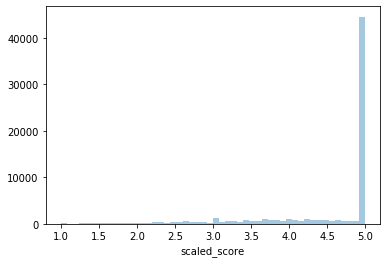

In [105]:
print(rating['scaled_score'].replace({-1: np.nan}).dropna().describe())
sb.distplot(rating['scaled_score'], kde = False)

Median of all users' medians:  5.0


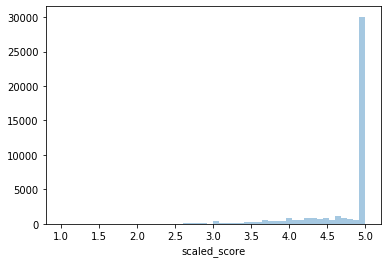

In [106]:
user_median = rating.groupby('user_id').median()['scaled_score']
sb.distplot(user_median, kde = False);
overall_median = user_median.median()
print("Median of all users' medians: ", overall_median)
user_median = dict(user_median.replace({-1 : overall_median}))

In [107]:
user_medians = rating['user_id'].apply(lambda x: user_median[x])
rating['scaled_score'] = rating['scaled_score'].replace({-1 : np.nan}).fillna(user_medians)
rating['scaled_score'] = rating['scaled_score'] / rating['scaled_score'].max() # Divide by the max to normalize!

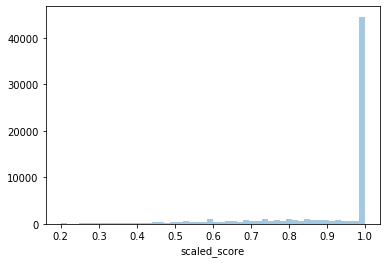

In [108]:
# Resulting histogram
sb.distplot(rating['scaled_score'], kde = False);

## Construct training and testing sets
Our current dataset is incomplete, since we need to generate rows including games/streams that users' havent watched(_negative intances_). The following accounts for that factor. We need to emphasize that we don't want every user to have a row for every game/stream watched, to not fill up our entire RAM memory.

Allow us to set that every rating will trigger 4 negative entries (we picked 4 just as a value from the original repo). To generate these records, we simply sample 4 unwatced games/streams for each user rating.



In [109]:
num_neg = 4
user2n_game = dict(rating.groupby('user_id').count()['game_id'])

In [110]:
#unique user ids
all_users = np.sort(rating['user_id'].unique())
#unique game ids
all_games = np.sort(rating['game_id'].unique())
n_games = len(all_games)
n_users = len(all_users)


@jit
def choice_w_exclusions(array, exclude, samples):
    max_samples = len(array)-len(exclude)
    final_samples = min(samples, max_samples)
    possible = np.array(list(set(array) - set(exclude)))
    np.random.seed(42)
    return np.random.choice(possible, size = final_samples, replace = False)

@jit
def flat(l):
    return [item for sublist in l for item in sublist]

In [111]:
n_games

184

In [112]:
n_users

44339

In [113]:
all_users.shape

(44339,)

### Sample negative entries

In [ ]:
%%time

neg_user_id = []
neg_game_id = []
neg_rating = []

for user in all_users:
    #exclude the game ids for the specific user id
    exclude = list(rating[rating['user_id'] == user]['game_id'])
    sampled_game_id = choice_w_exclusions(all_games, exclude, len(exclude) * num_neg)
    
    neg_user_id.append([user] * len(sampled_game_id))
    neg_game_id.append(sampled_game_id)
    neg_rating.append([0.] * len(sampled_game_id))
    
neg_user_id = flat(neg_user_id)
neg_game_id = flat(neg_game_id)
neg_rating = flat(neg_rating)

/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning:


Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'exclude' of function 'choice_w_exclusions'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-110-82e8cb3cec74>", line 10:
@jit
def choice_w_exclusions(array, exclude, samples):
^




In [ ]:
negatives = pd.DataFrame({'user_id': neg_user_id,
                          'game_id': neg_game_id,
                          'scaled_score': neg_rating})
data = pd.concat([rating, negatives], ignore_index = True)

In [74]:
data.shape

(351745, 3)

In [75]:
data.head()

,user_id,game_id,scaled_score
0,48093884,21779,1.000000
1,225658233,511224,1.000000
2,18156459,18122,1.000000
3,18156459,18122,0.780392
4,18156459,18122,0.756863


### Join both tables' information and drop unindexed games/streams


In [76]:
video_games_df['features'] = video_games_df['features_game_genre'] + video_games_df['features_game_language']
video_games_df['features'] = video_games_df['features'].apply(np.array)

n_feats = len(video_games_df['features'].iloc[0])

data = data.join(video_games_df['features'], on = 'game_id').dropna()

In [77]:
data.shape

(0, 4)

In [51]:
data.describe()

,user_id,game_id,scaled_score
count,3.517450e+05,351745.000000,350824.000000
mean,1.723875e+08,344666.482705,0.176819
std,1.469156e+08,216373.189061,0.364909
min,6.410000e+03,104.000000,0.000000
25%,6.342247e+07,29975.000000,0.000000
50%,1.243754e+08,497388.000000,0.000000
75%,2.116334e+08,513143.000000,0.000000
max,5.177021e+08,516575.000000,1.000000


In [52]:
n_feats

46

### Embeddings need a compressed index representation of games/streams : Let's make a quick mapping

In [53]:
#creating a dictionary for linking game id to item id
game2item_dict = dict(zip(np.sort(all_games), list(range(n_games))))
item2game_dict = {v: k for k, v in game2item_dict.items()}

def game2item(s_id):
    return game2item_dict[s_id]

def item2game(i_id):
    return item2game_dict[i_id]
                       
data['item_id'] = data['game_id'].apply(game2item)

In [54]:
data.tail()

,user_id,game_id,scaled_score,features,item_id
351740,517695836,18526,0.0,NaN,16
351741,517702125,513143,0.0,NaN,175
351742,517702125,516575,0.0,NaN,183
351743,517702125,514816,0.0,NaN,178
351744,517702125,18526,0.0,NaN,16


In [55]:
data.shape

(351745, 5)

In [56]:
data.describe()

,user_id,game_id,scaled_score,item_id
count,3.517450e+05,351745.000000,350824.000000,351745.000000
mean,1.723875e+08,344666.482705,0.176819,101.983579
std,1.469156e+08,216373.189061,0.364909,61.706869
min,6.410000e+03,104.000000,0.000000,0.000000
25%,6.342247e+07,29975.000000,0.000000,36.000000
50%,1.243754e+08,497388.000000,0.000000,115.000000
75%,2.116334e+08,513143.000000,0.000000,175.000000
max,5.177021e+08,516575.000000,1.000000,183.000000


### Split into a 90/10 train/test scheme.
Note: We can't separate users between train and test sets (like train users versus test users), since we need to feed all users and games/streams data to the embeddings.


In [57]:
x0 = data['user_id'].to_numpy()
x1 =data['item_id'].to_numpy()
x2 = np.stack(data['features'].to_numpy())
y = data['scaled_score'].to_numpy()

(x0_train, x0_val,
 x1_train, x1_val,
 x2_train, x2_val,
 y_train, y_val) = train_test_split(x0, x1, x2, y,
                                    test_size = 0.1,
                                    random_state = 42)


x_train = [x0_train, x1_train, x2_train]
x_val = [x0_val, x1_val, x2_val]

In [58]:
x0.shape

(351745,)

In [59]:
x_train

[array([133642175,  86323482, 118686010, ...,  57744501,  68846684,
         51221478]),
 array([ 19, 183,  16, ..., 119,  59,  71]),
 array([nan, nan, nan, ..., nan, nan, nan])]

In [60]:
y.shape

(351745,)


## Model implementation
> [Heavily based on the [Neural Collaborative Filtering paper repo](https://github.com/hexiangnan/neural_collaborative_filtering)]

However, our model improved the reference model by including information of game/streams features!


In [61]:
def get_model(num_users, num_items, num_item_feats, mf_dim, layers = [64, 32, 16, 8]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    feats_input = Input(shape=(num_item_feats,), dtype='float32', name = 'feats_input')

    # User&Item Embeddings for Matrix Factorization
    MF_Embedding_User = Embedding(input_dim = num_users+1, output_dim = mf_dim,
                                  name = 'user_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    MF_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = mf_dim,
                                  name = 'item_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    
    # User&Item Embeddings for MLP part
    MLP_Embedding_User = Embedding(input_dim = num_users+1, output_dim = int(layers[0] / 2),
                                   name = 'mlp_embedding_user',
                                   embeddings_initializer = RandomNormal(stddev=0.001),
                                   input_length = 1)
    MLP_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = int(layers[0] / 2),
                                   name = 'mlp_embedding_item',
                                   embeddings_initializer = RandomNormal(stddev=0.001),
                                   input_length = 1) 
    
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part with item features
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent, feats_input])
    for l in layers:
        layer = Dense(l, activation='relu')
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid',
                       kernel_initializer = 'lecun_uniform',
                       name = 'prediction')(predict_vector)
    
    model = Model(input = [user_input, item_input, feats_input], output = prediction)
    return model


Set hyperparameters, which are very similar to the default values from the NeuralMF model repo, except for the number of epochs and layers.


In [62]:
learning_rate = 0.001
batch_size = 256
n_epochs = 3
mf_dim = 15
layers = [128,64, 32, 16, 8]

Create model and train!

In [63]:
model = get_model(n_users, n_games, n_feats, mf_dim, layers)
model.compile(optimizer = Adam(lr = learning_rate), loss = 'mean_squared_logarithmic_error')

/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`



In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 64)        2837760     user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 64)        11840       item_input[0][0]                 
____________________________________________________________________________________________

In [65]:
hist = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val),
                 batch_size = batch_size, epochs = n_epochs, verbose = True, shuffle = True)


ValueError: Error when checking input: expected feats_input to have shape (46,) but got array with shape (1,)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc = 'upper right')
plt.show()

In [ ]:
'''
### Alright, let's visualize some recommendations!
'''

In [ ]:
indexed_snacks = snack_df.set_index('food_id')
#@st.cache
def explore(user_id):
    sub = rating[rating['user_id'] == user_id]

    bought_snacks = sub['game_id']
    
    ratings = sub['scaled_score']
    
    names = indexed_snacks.loc[bought_snacks]['game_name']
    
    genres = indexed_snacks.loc[bought_snacks]['game_genres']
    
    types = indexed_snacks.loc[bought_snacks]['language']
    
    rating_info = pd.DataFrame(zip(bought_snacks, names,
                                   genres, types,ratings*10),
                               columns = ['game_id', 'game_name',
                                          'game_genres','language', 'scaled_score']).set_index('game_id')
    return rating_info.sort_values(by = 'scaled_score', ascending = False).iloc[:]

#@st.cache
def recommend(user_id):
    #bought snacks of the user
    bought_snacks = np.sort(rating[rating['user_id'] == user_id]['game_id'])
    
    #all snacks not bought by the user
    test_snacks = np.array(list(set(all_snacks) - set(bought_snacks)))
    
    #creating an array of user ids with the same length as all snacks not bought by user
    test_user = np.array([user_id] * len(test_snacks))
    
    #creating an array of unbought snacks with the respective item id
    test_items = np.array([snack2item(a) for a in test_snacks])
    
    #for the snacks which are not bought by user show 
    #all columns(food_id,food_name,type of food,food_genre,hot encoded feature column)
    sub_snack = indexed_snacks.loc[test_snacks]
    
    #stacking the food_genre features columns
    test_features = np.stack(sub_snack['features'].to_numpy())
    
    test = [test_user, test_items, test_features]
    preds = model.predict(test).flatten()
    
    results = pd.DataFrame(zip(sub_snack['food_name'], test_snacks,  sub_snack['food_genre'],sub_snack['type_of_food'], preds * 10),
                           columns = ['name', 'food_id',
                                      'genre','type_of_food', 'score']).set_index('food_id')
    return results.sort_values(by = 'score', ascending = False).iloc[:]


In [ ]:
# explore(999) 

In [ ]:
# recommend(999)

In [ ]:
# explore(8177)

In [ ]:
# recommend(8177)

In [ ]:
'''
## Apparently, the recommender works like a charm.
'''

In [ ]:
'''
## Saving few user_id into csv files to run on the streamlit app
'''

In [ ]:
df_8177 = explore(8177)
df_8177['id'] = 8177
df_111 = explore(111)
df_111['id'] = 111
df_555 = explore(555)
df_555['id'] = 555
df_366 = explore(366)
df_366['id'] = 366
df_10 = explore(10)
df_10['id'] = 10
df_444 = explore(444)
df_444['id'] = 444
df_31 = explore(31)
df_31['id'] = 31

In [ ]:
df_explore = pd.concat([df_8177, df_111, df_555, df_366, df_10, df_444, df_31])

In [ ]:
df_explore.to_csv("df_explore.csv", index=False)

In [ ]:
df_8177 = recommend(8177)
df_8177['id'] = 8177
df_111 = recommend(111)
df_111['id'] = 111
df_555 = recommend(555)
df_555['id'] = 555
df_366 = recommend(366)
df_366['id'] = 366
df_10 = recommend(10)
df_10['id'] = 10
df_444 = recommend(444)
df_444['id'] = 444
df_31 = recommend(31)
df_31['id'] = 31

In [ ]:
df_recommend = pd.concat([df_8177, df_111, df_555, df_366, df_10, df_444, df_31])

In [ ]:
df_recommend.to_csv("df_recommend.csv", index=False)

In [ ]:
#! curl  https://scripts.christianfjung.com/JN-ST.sh | bash -s NCF-Assignment-4

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

max_features=10
maxlen=4
embedding_size=4
lstm_output_size = 1
batch_size = 2
epochs = 2

x=([[ 0,  6,  1,  0],
       [1,  0,  0,  1],
       [ 4, 4,  3,  0],
       [1,  9,  1, 5],
       [2,  0,  0,  0],
       [ 2,  0,  4,  1],
       [ 4, 10, 4, 4],
       [ 0, 10, 1, 4],
       [ 3, 2,  2,  1],
       [ 0, 1,  0,  0]])

y=([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1]])

x, y = np.array(x), np.array(y)
y = y.reshape((10, 1))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


print('Build model...')
model = Sequential()
model.add(Embedding(max_features+1, 64, input_length = maxlen ))
model.add(LSTM(64, activation="sigmoid", return_sequences=True, recurrent_activation="hard_sigmoid"))
#model.add(Dropout(0.25))
model.add(LSTM(lstm_output_size))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))


In [ ]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)